
載入相關函式庫


In [3]:
# 把一些警告的訊息暫時関掉
import warnings
warnings.filterwarnings('ignore')

# Utilities相關函式庫
import os
import numpy as np

# 圖像處理/展現的相關函式庫
import dlib
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt


設定相關設定與參數


In [4]:
# 專案的根目錄路徑
ROOT_DIR = "/home/andy/AILab/AIfinal/gaze_redirection-master/"

# 訓練/驗證用的資料目錄
DATA_PATH = os.path.join(ROOT_DIR, "reordered_face_dataset")

# 模型資料目錄
MODEL_PATH = os.path.join(ROOT_DIR, "eyescatch/model")

MODEL_FILE_PATH = os.path.join(MODEL_PATH, "shape_predictor_68_face_landmarks.dat")

# 測試用圖像
TEST_IMAGE = os.path.join(ROOT_DIR, "2004andy2.JPG")

#64乘64輸出圖
OUTPUT_PATH = os.path.join(ROOT_DIR, "eyespatch_dataset")

步驟1：定位圖像中的臉部邊界框

In [14]:
# 使用dlib自帶的frontal_face_detector作為我們的人臉偵測器
face_detector = dlib.get_frontal_face_detector()

# 載入圖像檔
image = Image.open(TEST_IMAGE)

# 把PIL.Image的物作轉換成numpy ndarray
img = np.array(image)

In [6]:
# 使用檢測器進行人臉檢測dets為返回的結果
# 第二個參數中的1表示把原始圖像變大，讓演算法能夠發現更多的人臉。
dets = face_detector(img, 0) # 因為測試的圖像己經很大了, 因此我們不啟動upsampling

# dets的元素個數即為偵測到臉的個數
print("Number of faces detected: {}".format(len(dets)))

Number of faces detected: 1


Detection 0: Left: 738 Top: 652 Right: 996 Bottom: 910


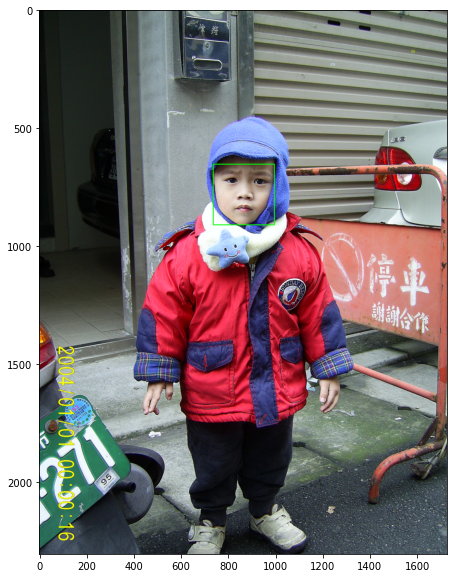

In [7]:
# 複製原始圖像
image_copy = image.copy()

# 在image_copy圖像上繪圖
img_draw = ImageDraw.Draw(image_copy)

# 迭代每一個偵測出來的邊界框
# left：人臉左邊距離圖片左邊界的距離; right：人臉右邊距離圖片左邊界的距離
# top：人臉上邊距離圖片上邊界的距離; bottom：人臉下邊距離圖片上邊界的距離
for i, d in enumerate(dets):
    x1 = d.left()
    y1 = d.top()
    x2 = d.right()
    y2 = d.bottom()
    
    print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}"
        .format( i, d.left(), d.top(), d.right(), d.bottom()))
    
    # 透過畫線來畫一個四方框的框線並控制粗細
    img_draw.line([(x1,y1),(x2,y1),(x2,y2),(x1,y2),(x1,y1)], fill='#00FF00', width=4)
    
plt.figure(figsize=(20,10))
plt.imshow(image_copy); plt.show()

標出眼睛的點

In [8]:
'''
image_copy = image.copy()
# 獲取左眼和右眼的特徵點位置
left_eye_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
right_eye_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]
# 將特徵點繪製在圖片上
for point in left_eye_points:
    plt.plot(point[0], point[1], 'bo', markersize=2) # 左眼用藍色的點

for point in right_eye_points:
    plt.plot(point[0], point[1], 'ro', markersize=2)  # 右眼用紅色的點

# 顯示圖片
plt.imshow(image)
plt.axis('off')  # 關閉座標軸
plt.show()
'''

"\nimage_copy = image.copy()\n# 獲取左眼和右眼的特徵點位置\nleft_eye_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]\nright_eye_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]\n# 將特徵點繪製在圖片上\nfor point in left_eye_points:\n    plt.plot(point[0], point[1], 'bo', markersize=2) # 左眼用藍色的點\n\nfor point in right_eye_points:\n    plt.plot(point[0], point[1], 'ro', markersize=2)  # 右眼用紅色的點\n\n# 顯示圖片\nplt.imshow(image)\nplt.axis('off')  # 關閉座標軸\nplt.show()\n"

匡出眼睛

Detection 0: Left: 738 Top: 652 Right: 996 Bottom: 910


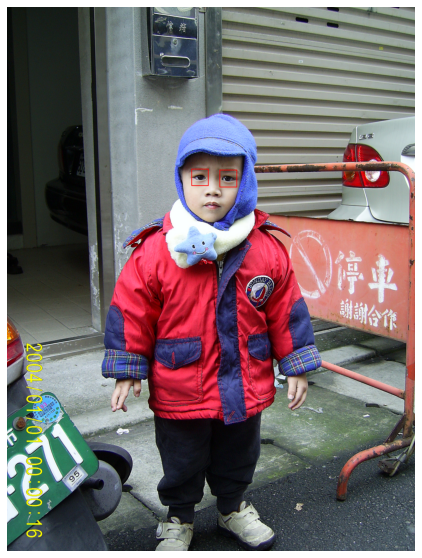

In [9]:
predictor = dlib.shape_predictor(MODEL_FILE_PATH)  # 使用您設定的模型路徑
image_copy = image.copy()
img_draw_eyes = ImageDraw.Draw(image_copy)

# 遍歷每個偵測到的人臉
for i, d in enumerate(dets):
    x1 = d.left()
    y1 = d.top()
    x2 = d.right()
    y2 = d.bottom()
    
    print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}"
          .format(i, d.left(), d.top(), d.right(), d.bottom()))
    
    # 使用 Dlib 的特徵點偵測器
    landmarks = predictor(img, d)

    # 獲取左眼和右眼的特徵點位置
    left_eye_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
    right_eye_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]

    # 計算眼睛區域的邊界框
    left_eye_x1 = min([p[0] for p in left_eye_points])
    left_eye_y1 = min([p[1] for p in left_eye_points])
    left_eye_x2 = max([p[0] for p in left_eye_points])
    left_eye_y2 = max([p[1] for p in left_eye_points])

    right_eye_x1 = min([p[0] for p in right_eye_points])
    right_eye_y1 = min([p[1] for p in right_eye_points])
    right_eye_x2 = max([p[0] for p in right_eye_points])
    right_eye_y2 = max([p[1] for p in right_eye_points])

    # 計算正方形的邊長，以長邊為主，並放大1.5倍
    left_eye_width = left_eye_x2 - left_eye_x1
    left_eye_height = left_eye_y2 - left_eye_y1
    left_eye_size = int(1.5 * max(left_eye_width, left_eye_height))

    right_eye_width = right_eye_x2 - right_eye_x1
    right_eye_height = right_eye_y2 - right_eye_y1
    right_eye_size = int(1.5 * max(right_eye_width, right_eye_height))

    # 更新左眼和右眼的邊界框，使其為放大1.5倍的正方形，並保持中心不變
    left_eye_center_x = (left_eye_x1 + left_eye_x2) // 2
    left_eye_center_y = (left_eye_y1 + left_eye_y2) // 2
    left_eye_x1 = left_eye_center_x - left_eye_size // 2
    left_eye_x2 = left_eye_center_x + left_eye_size // 2
    left_eye_y1 = left_eye_center_y - left_eye_size // 2
    left_eye_y2 = left_eye_center_y + left_eye_size // 2

    right_eye_center_x = (right_eye_x1 + right_eye_x2) // 2
    right_eye_center_y = (right_eye_y1 + right_eye_y2) // 2
    right_eye_x1 = right_eye_center_x - right_eye_size // 2
    right_eye_x2 = right_eye_center_x + right_eye_size // 2
    right_eye_y1 = right_eye_center_y - right_eye_size // 2
    right_eye_y2 = right_eye_center_y + right_eye_size // 2

    # 在左眼和右眼位置畫出框線
    img_draw_eyes.rectangle([left_eye_x1, left_eye_y1, left_eye_x2, left_eye_y2], outline="red", width=3)
    img_draw_eyes.rectangle([right_eye_x1, right_eye_y1, right_eye_x2, right_eye_y2], outline="red", width=3)

# 顯示結果
plt.figure(figsize=(20, 10))
plt.imshow(image_copy)
plt.axis("off")
plt.show()


調整一下眼睛大小（64*64）

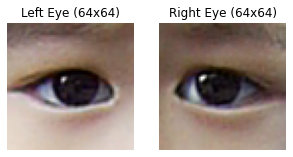

In [10]:
# 複製原始圖像
image_copy = image.copy()
# 將 PIL 圖像轉換為 OpenCV 的 NumPy 陣列格式
image_np = np.array(image_copy)
# 假設我們已經從 Dlib 得到左眼和右眼的邊界框座標
left_eye = image.crop((left_eye_x1, left_eye_y1, left_eye_x2, left_eye_y2))
right_eye = image.crop((right_eye_x1, right_eye_y1, right_eye_x2, right_eye_y2))

# 將左眼和右眼的圖像大小調整為校正模型的輸入大小，例如 64x64
left_eye_resized = left_eye.resize((64, 64))
right_eye_resized = right_eye.resize((64, 64))

# 顯示調整大小後的圖像
# 使用 matplotlib 在 Notebook 中顯示調整大小後的眼睛
fig, axes = plt.subplots(1, 2, figsize=(5, 5))
axes[0].imshow(left_eye_resized)
axes[0].set_title("Left Eye (64x64)")
axes[0].axis("off")

axes[1].imshow(right_eye_resized)
axes[1].set_title("Right Eye (64x64)")
axes[1].axis("off")

plt.show()


接下來理論上是把這兩顆眼睛丟進去眼球校正的model裡

調整回原本大小的眼睛，並透過cv2.seamlessClone讓貼回去的眼鏡是看起來正常的

In [11]:
'''
import cv2
# 將調整過的眼睛圖像轉換回 NumPy 格式
left_eye_corrected_np = np.array(left_eye_resized)
right_eye_corrected_np = np.array(right_eye_resized)

# 調整回原始大小
left_eye_corrected_resized = cv2.resize(left_eye_corrected_np, (left_eye_x2 - left_eye_x1, left_eye_y2 - left_eye_y1))
right_eye_corrected_resized = cv2.resize(right_eye_corrected_np, (right_eye_x2 - right_eye_x1, right_eye_y2 - right_eye_y1))

# 創建遮罩，白色區域代表融合的區域
left_eye_mask = 255 * np.ones(left_eye_corrected_resized.shape, left_eye_corrected_resized.dtype)
right_eye_mask = 255 * np.ones(right_eye_corrected_resized.shape, right_eye_corrected_resized.dtype)

# 定義中心點
left_eye_center = ((left_eye_x1 + left_eye_x2) // 2, (left_eye_y1 + left_eye_y2) // 2)
right_eye_center = ((right_eye_x1 + right_eye_x2) // 2, (right_eye_y1 + right_eye_y2) // 2)

# 使用 cv2.seamlessClone 進行無縫融合
image_np = cv2.seamlessClone(left_eye_corrected_resized, image_np, left_eye_mask, left_eye_center, cv2.NORMAL_CLONE)
image_np = cv2.seamlessClone(right_eye_corrected_resized, image_np, right_eye_mask, right_eye_center, cv2.NORMAL_CLONE)

# 將結果轉回 PIL 格式以便顯示
output_image = Image.fromarray(image_np)

# 顯示結果
plt.figure(figsize=(20, 10))
plt.imshow(output_image)
plt.axis("off")
plt.show()
'''

'\nimport cv2\n# 將調整過的眼睛圖像轉換回 NumPy 格式\nleft_eye_corrected_np = np.array(left_eye_resized)\nright_eye_corrected_np = np.array(right_eye_resized)\n\n# 調整回原始大小\nleft_eye_corrected_resized = cv2.resize(left_eye_corrected_np, (left_eye_x2 - left_eye_x1, left_eye_y2 - left_eye_y1))\nright_eye_corrected_resized = cv2.resize(right_eye_corrected_np, (right_eye_x2 - right_eye_x1, right_eye_y2 - right_eye_y1))\n\n# 創建遮罩，白色區域代表融合的區域\nleft_eye_mask = 255 * np.ones(left_eye_corrected_resized.shape, left_eye_corrected_resized.dtype)\nright_eye_mask = 255 * np.ones(right_eye_corrected_resized.shape, right_eye_corrected_resized.dtype)\n\n# 定義中心點\nleft_eye_center = ((left_eye_x1 + left_eye_x2) // 2, (left_eye_y1 + left_eye_y2) // 2)\nright_eye_center = ((right_eye_x1 + right_eye_x2) // 2, (right_eye_y1 + right_eye_y2) // 2)\n\n# 使用 cv2.seamlessClone 進行無縫融合\nimage_np = cv2.seamlessClone(left_eye_corrected_resized, image_np, left_eye_mask, left_eye_center, cv2.NORMAL_CLONE)\nimage_np = cv2.seamlessClone(

In [13]:
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

# 加載 Dlib 模型
face_detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(MODEL_FILE_PATH)

# 定義處理圖像的函式
def process_image(image_path, output_folder):
    image = Image.open(image_path)
    img = np.array(image)
    dets = face_detector(img, 0)
    
    # 如果未偵測到人臉，跳過該圖像
    if len(dets) == 0:
        print(f"No faces detected in {image_path}")
        return
    
    for d in dets:
        landmarks = predictor(img, d)
        left_eye_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
        right_eye_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]

        # 計算左眼和右眼的正方形區域
        left_eye_x1 = min([p[0] for p in left_eye_points])
        left_eye_y1 = min([p[1] for p in left_eye_points])
        left_eye_x2 = max([p[0] for p in left_eye_points])
        left_eye_y2 = max([p[1] for p in left_eye_points])

        right_eye_x1 = min([p[0] for p in right_eye_points])
        right_eye_y1 = min([p[1] for p in right_eye_points])
        right_eye_x2 = max([p[0] for p in right_eye_points])
        right_eye_y2 = max([p[1] for p in right_eye_points])

        # 計算正方形區域大小並放大
        left_eye_size = int(1.5 * max(left_eye_x2 - left_eye_x1, left_eye_y2 - left_eye_y1))
        right_eye_size = int(1.5 * max(right_eye_x2 - right_eye_x1, right_eye_y2 - right_eye_y1))

        left_eye_center_x = (left_eye_x1 + left_eye_x2) // 2
        left_eye_center_y = (left_eye_y1 + left_eye_y2) // 2
        left_eye_x1 = left_eye_center_x - left_eye_size // 2
        left_eye_x2 = left_eye_center_x + left_eye_size // 2
        left_eye_y1 = left_eye_center_y - left_eye_size // 2
        left_eye_y2 = left_eye_center_y + left_eye_size // 2

        right_eye_center_x = (right_eye_x1 + right_eye_x2) // 2
        right_eye_center_y = (right_eye_y1 + right_eye_y2) // 2
        right_eye_x1 = right_eye_center_x - right_eye_size // 2
        right_eye_x2 = right_eye_center_x + right_eye_size // 2
        right_eye_y1 = right_eye_center_y - right_eye_size // 2
        right_eye_y2 = right_eye_center_y + right_eye_size // 2

        # 裁剪並調整大小
        left_eye = image.crop((left_eye_x1, left_eye_y1, left_eye_x2, left_eye_y2)).resize((64, 64))
        right_eye = image.crop((right_eye_x1, right_eye_y1, right_eye_x2, right_eye_y2)).resize((64, 64))

        # 儲存處理後的圖像
        left_eye.save(os.path.join(output_folder, f"left_{os.path.basename(image_path)}"))
        right_eye.save(os.path.join(output_folder, f"right_{os.path.basename(image_path)}"))

# 遍歷每個子資料夾和圖像
for subfolder in os.listdir(DATA_PATH):
    subfolder_path = os.path.join(DATA_PATH, subfolder)
    output_subfolder = os.path.join(OUTPUT_PATH, subfolder)

    if not os.path.exists(output_subfolder):
        os.makedirs(output_subfolder)
    
    if os.path.isdir(subfolder_path):
        for image_file in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_file)
            if image_file.lower().endswith(('.jpg', '.png', '.jpeg')):
                process_image(image_path, output_subfolder)

OSError: image file is truncated (1 bytes not processed)